# 이미지 분류하기
합성곱 신경망을 이해하려면 먼저 합성곱 연산과 교차 상관 연산에 대해 알아야 한다.  
앞으로 합성곱 연산을 합성곱, 교차상관 연산을 교차상관이라고 줄여 부르겠다.  

</br>

## 합성곱 이해하기

두 배열 x와 w가 있다.  
이 중 원소수가 적은 배열 w의 원소 순서를 뒤집는다.  
이 뒤집은 w를 w^r이라고 한다.  
w^r의 첫 부분을 x의 첫 부분과 맞춰 놓고 서로 곱한다.  
예를 들어 아래와 같다고 가정해보자  
```python
 x = [2, 8, 3, 7, 1, 2, 0, 4, 5]
w^r= [3, 5, 1, 2]
```
이때 각 원소를 곱한 뒤 더한 식은 다음과 같다.  
```
2 * 3 + 9 * 5 + 3 * 1 + 7 * 2 = 63
```
즉, 첫 번째 합성곱의 결과는 63이다.  
  
w^r을 오른쪽으로 한 칸 이동해서 같은 방식으로 곱한 뒤 더한다.  
이때 얻은 값은 48이다.  
</br>

같은 방식으로 끝에 도달할 때까지 반복한다.  
이 때, 얻는 값은 차례대로  
63, 48, 49, 28, 21, 20이다.  
이와 같은 합성곱 수식은 x * w와 같이 표기한다.  
기존의 곱하기와 혼동할 수 있음을 주의  
</br>





## 합성곱 구현하기
넘파이로 구현할 수 있다.  

In [1]:
# 예시 배열 만들고 합성곱 구현하기
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])
w_r = np.flip(w)      # filp 메서드로 간단하게 뒤집을 수 있다. 
print(w_r)

[3 5 1 2]


물론 파이썬의 슬라이스 연산자로 뒤집을 수도 있다.  
```python
w_r = w[::-1]
print(w_r)
# 결과: [3 5 1 2]
```

In [2]:
# 넘파이의 점곱으로 합성곱 수행
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


## 싸이파이로 합성곱 수행하기
싸이파이는 합성곱을 위한 함수 convolve를 제공한다.  

In [3]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

## 합성곱 신경망은 진짜 합성곱을 사용하지 않는다.
사실 대부분의 딥러닝 패키지들은 합성곱 신경망을 만들 때  
합성곱이 아닌 교차상관을 사용한다.  
교차상관에 대해 알아보자  
</br>

교차상관은 합성곱과 동일한 방법으로 연산이 진행되지만  
'미끄러지는 배열을 뒤집지 않는다' 는 점이 다르다.  
  
그러니까 선술한 합성곱에서 뒤집는 과정만 없는 것이다.  
</br>

마찬가지로 교차상관은 싸이파이의 correlate() 함수를 사용하여  
구현할 수 있다.  

In [4]:
# 싸이파이로 교차상관 구현하기
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

그럼 왜 합성곱 대신 교차상관을 쓰는 걸까?  
모델 훈련시 가중치 배열을 초기화 하는 과정을 생각해보자
```
모델 훈련과정 간단정리
1. 가중치를 무작위 값으로 초기화
2. 모든 샘플에 대해 정방향과 역방향 계산을 수행하여 가중치를 조금씩 학습(업데이트) 한다.
```
'미끄러지는 배열'이 가중치 배열에 해당한다.  
가중치 배열은 무작위로 초기화 되는데 따라서 가중치를 뒤집든 안 뒤집든  
딱히 상관이 없다.  
하지만 합성곱 신경망이라는 이름을 관례적으로 널리 사용하다보니  
그냥 이렇게 부르는 것이다.  

</br>
이제 합성곱 신경망의 핵심인 패딩과 스트라이드에 대해 알아보자  


# 패딩과 스트라이드
패딩은 원본 배열의 양 끝에 빈 원소를 추가하는 것이고  
스트라이드는 미끄러지는 배열의 간격을 조절하는 것이다.  
패딩은 밸리드, 풀, 세임으로 나뉘는데 순서대로 알아보자  

</br>

### 밸리드 패딩
자, 짧은 배열은 미끄러지면서 합성곱 연산에 참가하는데  
이때 긴 배열의 첫 번째 원소는 계산에 한 번만 참가하고 그 뒤의 원소들은  
그보다 더 많이 참가할 것이다.  
즉, 각 원소가 연산에 참여하는 정도가 다르다는 것이다. 
다음과 같이 구현할 수 있다.  
```python
correlate(x, w, mode='valid')
``` 

</br>
  
### 풀 패딩
풀 패딩은 모든 원소가 연산에 동일하게 참가시키기 위해 양 끝에  
가상의 원소를 추가한 것이다.  
이때 사용하는 가상의 원소 값은 0 이다.(때문에 제로패딩이라고도 한다.)  
다음과 같이 구현할 수 있다.  
```python
correlate(x, w, mode='full')
```

</br>

### 세임 패딩
세임 패딩은 긴 배열과 출력 배열의 길이가 같아지도록  
원본 배열의 앞부분에 제로패딩을 추가한 것이다.  
다음과 같이 구현할 수 있다.  
```python
correlate(x, w, mode='same')
```

</br>

### 스트라이드
스트라이드는 미끄러지는 간격을 조정한다.  
지금까지는 미끄러지는 간격이 1칸씩이었는데  
이걸 조정해서 2칸, 또는 그 이상으로 조절할 수 있다.  


# 2차원 배열에서의 합성곱
2차원 배열의 합성곱도 1차원 배열의 합성곱과 비슷하게 수행된다.  
아래와 같은 두 배열이 있다고 가정해보자  
```
x = 
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]

w = 
[2, 0]
[0, 0]
```
작은 배열의 큰 배열 부분에 합성곱을 시작한다.  
첫 번째는 x 배열의 다음과 같은 부분에 계산이 된다.  
```
x 배열의 일부분
[1, 2]
[4, 5]
```
이 부분과 w 배열의 합성곱은 다음과 같다.  
1 x 2 + 2 X 0 + 4 X 0 + 5 X 0  
  
다음 계산 배열은 다음 부분과 같다.  
```
x 배열의 2번째 계산 부분
[2, 3]
[5, 6]
```
이 부분을 하고 나면 오른쪽 끝에 도달했으므로 다음엔  
다시 맨 왼쪽 한 칸 아래를 계산하면 된다.  
즉, 계산횟수는 총 4번이다.  

</br>

싸이파이의 correlate2d() 함수를 통해 2차원 배열 합성곱을 계산해보자  

In [5]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])

from scipy.signal import correlate2d

correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

2차원 배열의 패딩과 스트라이드도 알아보자  
세임패딩의 경우, 배열의 오른쪽과 아랫쪽에 제로 패딩이 추가된다.  
세임패딩을 사용했으므로 원본 배열 크기과 같은 출력 배열이 만들어 진다.  

</br>

스트라이드의 경우, 미끄러지는 방향은 유지한 체 간격만 조정된다.  


# 텐서플로로 합성곱을 수행
지금까지 싸이파이를 사용했는데 당연히 텐서플로에도 이 기능이 있다.  
텐서플로에서 2차원 합성곱 합수는 conv2d()이다.  
여기에 4차원 배열을 입력해야 한다.  
그 이유는 입력 이미지의 높이와 너비 외에 더 많은 차원이  
필요하기 때문이다.  

</br>

입력에 2개의 샘플이 있고 각 샘플은 R, G, B로 구분되는 3개의 채널을 가진다.  
각 샘플의 너비가 3 * 3이라면 이때 입력에 해당하는 4차원 배열은  
2 * 3 * 3 * 3 이며 순서대로 배치, 높이, 너비, 컬러채널을 의미한다.  
  
입력과 곱해지는 가중치도 4개의 차원으로 구성된다.  
첫 번째, 두 번째 차원은 가중치의 높이와 너비고 세 번째 차원은 채널이며  
네 번째 차원이 가중치의 개수이다.  

</br>

## 2차원 배열을 4차원 배열로 바꿔 합성곱을 수행
입력 x와 가중치 w를 넘파이의 reshape() 메서드로 2차원 배열에서 4차원으로 바꾼다.  
텐서플로는 실수형 입력을 기대하므로 넘파이의 astype() 메서드로 입력의  
자료형을 실수로 바꿔야 한다.   
배치와 컬러 채널은 1이다.  


In [6]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

<ipython-input-6-b5fc619af11d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_4d = x.astype(np.float).reshape(1, 3, 3, 1)


In [7]:
# 3, 3 크기로 치환하여 출력 
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

# 풀링 연산

합성곱 신경망에서는 합성곱이 일어나는 층을 합성곱층, 풀링이 일어나는 층을 풀링층이라고 부른다.  
합성곱층과 풀링층에서 만들어진 결과를 특성 맵이라고 부른다.  
RGB 컬러 채널을 가진 입력 이미지가 합성곱층과 풀링층을 거치면서 변환한다.  
아래는 풀링을 나타낸 이미지다.  

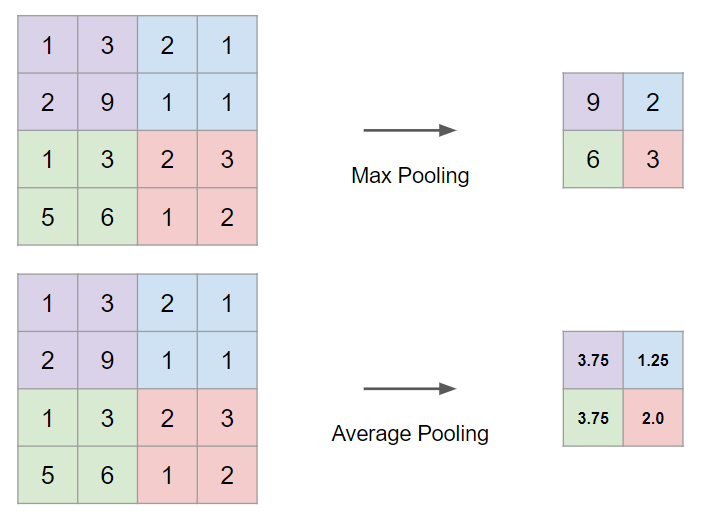

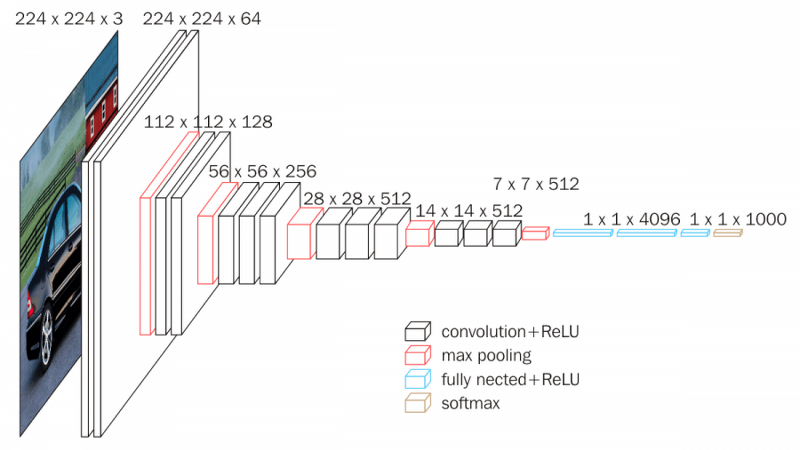


## 최대 풀링
최대 풀링은 풀링으로 최댓값을 고르는 것을 최대 풀링이라고 한다.  
최대 풀링은 특성 맵 위를 스캔하며 최댓값을 고른다.  
풀링 영역의 크기는 보통 2X2를 지정한다.  
스트라이드는 모서리의 크기 (위의 경우 2)로 지정한다.  
2 X 2 풀링은 특성 맵 크기를 절반으로 줄인다 (면적은 1/4)  
이로써 더 넓은 영역을 바라볼 수 있는 효과를 얻을 수 있다.  

## 평균 풀링
평균 풀링은 풀링 영역에서 평균값을 구하는 풀링이다.  
연구자들은 보통 평균 풀링보다 최대 풀링을 선호한다.  
왜냐하면 평균 풀링은 합성곱층을 통과하는 특징들을 희석시킬 가능성이 있기 때문이다.  
최대 풀링은 가장 큰 특징을 유지시키는 성질이 있으므로 이미지 분류 작업에 알맞다.  
이런 이유 때문에 최대 풀링을 더 선호한다.  

## 풀링수행

풀링을 직접 수행해보자

In [8]:
x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

이제 max_pool2d() 함수로 최대 풀링을 수행하면 된다.  

In [9]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

결과를 보니 제대로 최대풀링이 된 것 같다.

# 합성곱 신경망의 구조

## 렐루함수
합성곱층에서는 렐루함수를 활성화 함수로 자주 사용한다.  
렐루 함수의 모습은 아래와 같다.


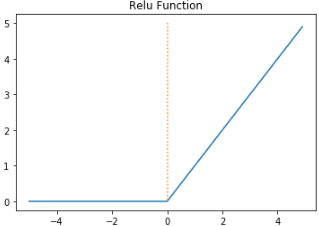

## 렐루 함수 구현
넘파이의 maximum() 함수를 통해 쉽게 구현할 수 있다.  

In [10]:
def relu(x):
    return np.maximum(x, 0)

잘 작동하는지 확인해보자

In [11]:
x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

음수가 모두 사라지고 양수만 반환된 것을 볼 수 있다.  
텐서플로에서는 relu() 함수를 사용한다.  
텐서플로의 렐루 함수는 Tensor 객체를 반환하므로 출력하려면 넘파이로 변환해야 한다.  

In [12]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

## 렐루 함수의 도함수
렐루 함수의 도함수는 입력이 0보다 크면 1, 작으면 0이다.  
때문에 기울기는 없다.  

</br>

## 합성곱 신경망에서 일어나는 일들과 구조

합성곱 신경망에 주입될 입력 데이터에는 채널이 있다.  
이미지의 2차원 형태를 그대로 사용하기 때문에 이미지를 한 줄로 펼칠 필요가 없다.  
때문에 이미지 정보가 손상되지 않는다는 장점이 있다.  
단, 이미지는 채널이라는 차원을 하나 더 가진다.  
채널이란 빨간색, 파란색, 초록색의 조합으로 표현하며 이를 RGB라고 한다.  

</br>

## 합성곱층에서 일어나는 일들

이미지의 모든 채널에 합성곱이 한 번에 적용되어야 하므로 커널의 마지막 차원은   입력 채널의 개수와 동일해야 한다.  
  
각 커널의 크기는 보통 3 X 3 또는 5 X 5 이다.  
3 X 3 크기의 커널을 사용한다면 커널 배열의 크기는 3 X 3 X 3 이다.  
만약 10개의 채널을 가져서 4 x 4 X 10의 구조를 가졌다면  
커널 배열의 크기도 3 X 3 X 10으로 마지막 차원의 개수를 동일하게 맞추어야 한다.  
아래는 합성곱 전체과정을 나타낸 것이다.  

</br>

최초에 가로 세로 4 X 4 에 RGB 채널을 가진 이미지가 있다.  
여기에 3 X 3 X 3 커널을 적용시키면 2 X 2 크기의 특성 맵이 만들어진다.  
  
4 X 4 크기의 이미지에 3 X 3 크기의 커널은 가로로 2번, 세로로 2번  
총 4번 수행될 수 있다.  
때문에 2 X 2 크기의 특성맵이 만들어 진다.  
  
커널의 수는 여러개 일 수 있다.  
이미지의 여러 특징을 감지하려면 커널을 여러 개 사용해야 한다.  
커널을 5개 사용한다고 가정해보자  
이 경우, 5개의 2 X 2 특성맵이 만들어 질 것이다.  

</br>

특성 맵은 2 X 2 X 5가 되었다.  
이 때, 2 X 2 풀링이 적용되면 1 X 1 X 5 크기의 특성맵이 만들어진다.  
즉, 특성 맵의 크기가 절반으로 줄어든다.  

</br>

합성곱층과 풀링층으으을 통과시켜서 얻은 특성맵은 일렬로 펼쳐서  
완전 연결층에 입력으로 주입한다.  
여기서는 1 X 1 X 5 이므로 5개의 입력이 출력층으로 거미줄처럼 전달된다.  


# 합성곱 신경망을 만들고 훈련하기

이제 합성곱 신경망을 직접 만들어보자  
단, 파이썬 만으로는 합성곱 신경망을 구현하려면 코드가 굉장히 복잡해지므로  
텐서플로가 제공하는 합성곱 함수와 자동 미분 기능을 사용해 합성곱 신경망을 구현해보자  

</br>



In [13]:
import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

위 코드를 찬찬히 살펴보자  
conv2d() 함수를 통해 합성곱을 수행한 다음  
절편 self.conv_b를 더해야 한다.  
절편은 커널마다 1개씩 필요하므로 총 10개의 절편이 필요하다.  
```python
def forpass(self, x):
    # 3x3 합성곱 연산을 수행합니다.
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
```
self.conv_w는 합성곱에 사용할 가중치다.  
3 X 3 X 1 커널을 10개 사용하므로 가중치의 전체 크기는  
3 X 3 X 1 X 10 이다.  
</br>
strides와 padding의 경우  
가로와 세로를 일정하게 하기 위해 strides는 1, padding은 same으로 한다.  
</br>
```python
def forpass(self, x):
    ...
    # 렐루 활성화 함수를 적용합니다.
    r_out = tf.nn.relu(c_out)
```
렐루 함수를 적용하여 합성곱층을 완성한다.  

</br>

```python
def forpass(self, x):
    ...
    # 2x2 최대 풀링을 적용합니다.
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
    # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
    f_out = tf.reshape(p_out, [x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
    a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
    z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
    return z2
```
max_pool2d() 함수로 2X2 풀링을 적용한다.  
그 다음 tf.reshape() 함수를 통해 일렬로 펼친다.  
이때, 배치 차원이 아닌 나머지 차원만 해야한다.  
np.dot() 함수를 텐서플로의 tf.matmul()함수로 바꾼다.  
이는 conv2d()와 max_poll2d() 등이 Tensor 객체를 반환하기 때문이다.  
활성화 함수도 시그모이드 대신 렐루 함수를 사용한다.  


## 역방향 계산

자동 미분 기능을 사용하려면  
ConvolutionNetwork의 backprop() 메서드를 구현할 필요가 없다.  
때문에 training() 메서드의 구성도 간단하다.


```python
def training(self, x, y):
    m = len(x)                    # 샘플 개수를 저장합니다.
    with tf.GradientTape() as tape:
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        # 손실을 계산합니다.
        loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
        loss = tf.reduce_mean(loss)
    ...
```

## 그레이디언트 계산

이제 그레이디언트를 계산해보자
```python
def training(self, x, y):
    m = len(x)                    # 샘플 개수를 저장합니다.
    with tf.GradientTape() as tape:
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        # 손실을 계산합니다.
        loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
        loss = tf.reduce_mean(loss)

    weights_list = [self.conv_w, self.conv_b,
                    self.w1, self.b1, self.w2, self.b2]
    # 가중치에 대한 그래디언트를 계산합니다.
    grads = tape.gradient(loss, weights_list)
    # 가중치를 업데이트합니다.
    self.optimizer.apply_gradients(zip(grads, weights_list))
```
tape.gradient() 메서드를 사용하면 그레이드엔트를 자동으로 계산할 수 있다.  

optimizer.apply_gradients(zip(grads, weights_list)) 메서드를 사용하여  
간단하게 알고리즘을 바꾸어 테스트 할 수 있다.  
apply_gradients 메서드는 그레이디언트와 가중치를 튜플로 묶은  
리스트를 전달해야 한다.  여기에서는 파이썬의 zip 반복자를 사용해  
구현한다.  








이제 이걸 사용하여 직접 합성곱 신경망을 훈련해보자

In [14]:
# 데이터 세트 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 훈련 데이터 세트를 훈련 세트와 검증세트로 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)
# 타깃을 원-핫 인코딩으로 변환
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

# 입력 데이터 준비
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

# 준비된 입력데이터 확인
x_train.shape

4422102/4422102 [==============================] - 0s 0us/step


(48000, 28, 28, 1)

In [15]:
# 입력 데이터 표준화 전처리
x_train = x_train / 255
x_val = x_val / 255

# 모델 훈련하기
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=20)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

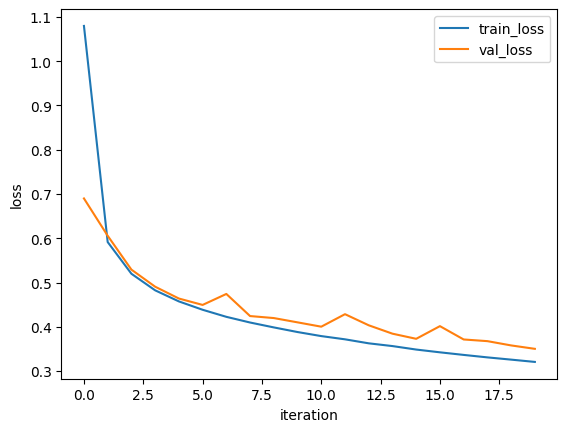

In [17]:
# 훈련과 검승, 손실 그래프, 그리고 검증세트의 정확도 확인하기
import matplotlib.pyplot as plt
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [18]:
# 점수 확인
cn.score(x_val, y_val_encoded)

0.8805

# 케라스로 합성곱 신경망 만들기
케라스의 합성곱층은 Conv2D 클래스다.  
최대 출링은 MaxPoloing2D 클래스를 사용하고  
특성 맵을 일렬로 펼칠 때는 Flatten 클래스를 사용한다.  

In [19]:
# 클래스 임포트
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [20]:
# 합성곱층, 풀링층 쌓기
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv1.add(MaxPooling2D((2, 2)))

In [21]:
# 완전 연결층에 주입할 수 있도록 특성맵 펼치기
conv1.add(Flatten())

In [22]:
# 완전 연결층 쌓기
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [23]:
# 모델 구조 살펴보기
conv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 100)               196100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
__________________________________________________

출력 크기는 28 X 28 X 10이다. (배치차원 제외)  
배치차원이 None인 이유는 훈련시 전달되는 샘플 개수에 따라 달라지기 때문이다.  
합성곱 채널은 10개이므로 마지막 차원이 10이다.  
모델 파라미터의 개수는 전체 가중치의 크기와 커널마다 하나씩 절편을 추가하면  
3 X 3 X 1 X 10 + 10 = 100개이다.  
</br>

첫 번째 완전 연결층에는 14 X 14 X 10 = 1960개의 입력이 100개의 뉴런에 연결된다.  
마찬가지로 두 번째 완전 연결층의 가중치 개수는 100 X 10 + 10 = 1010 개다.  


## 합성곱 신경망 모델 훈련하기  
이제 훈련해보자

In [24]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 35s 22ms/step - loss: 0.4439 - accuracy: 0.8428 - val_loss: 0.3245 - val_accuracy: 0.8844
Epoch 2/20
1500/1500 [==============================] - 36s 24ms/step - loss: 0.3042 - accuracy: 0.8899 - val_loss: 0.2799 - val_accuracy: 0.9008
Epoch 3/20
1500/1500 [==============================] - 26s 18ms/step - loss: 0.2568 - accuracy: 0.9064 - val_loss: 0.2662 - val_accuracy: 0.9038
Epoch 4/20
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2265 - accuracy: 0.9169 - val_loss: 0.2698 - val_accuracy: 0.9034
Epoch 5/20
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2011 - accuracy: 0.9259 - val_loss: 0.2500 - val_accuracy: 0.9119
Epoch 6/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1809 - accuracy: 0.9331 - val_loss: 0.2496 - val_accuracy: 0.9124
Epoch 7/20
1500/1500 [==============================] - 26s 17ms/step - loss: 0.1626 - accuracy: 0.9398 - val_loss: 0.2569 -

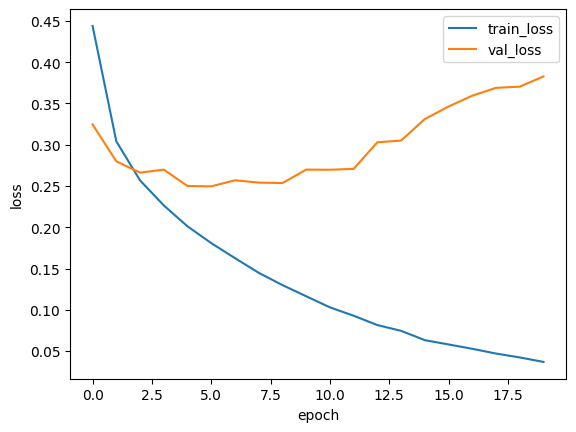

In [28]:
# 손실 그래프와 정확도 그래프 확인하기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

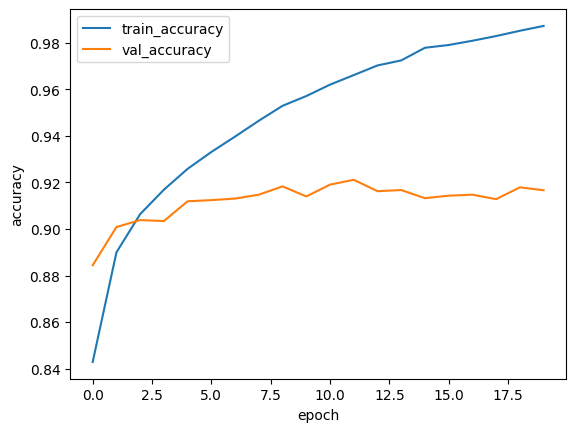

In [29]:
# 손실 그래프와 정확도 그래프 확인하기2
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# 드롭아웃
신경망에서 과대적합을 줄이는 방법 중 하나가 드롭아웃이다.  
드롭아웃은 무작위로 일부 뉴런을 비활성화 하는 것이다.  

</br>

일부 뉴런을 비활성화 되었을 때도 타깃 예측을 잘 해낸다면 특정 뉴런에  
과도하게 의존하지 않고 모든 뉴런이 의미있는 패턴을 학습해야 한다.  
모든 뉴런이 고르게 패턴을 학습하므로 일반화 성능이 높아진다.  
  
드롭아웃은 모델을 훈련시킬 때만 적용하는 기법이므로 테스트나 실전에는 사용하지 않는다.  

</br>

텐서플로에서 드롭아웃을 쓰려면 Dropout 클래스를 추가하면 된다.  



In [26]:
# 패키지 임포트
from tensorflow.keras.layers import Dropout

In [30]:
# 아까 위에 했던 방법 그대로 적용
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [31]:
# 드롭아웃 층 확인
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1960)              0         
                                                                 
 dropout (Dropout)           (None, 1960)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               196100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                      

In [32]:
# 훈련하기
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 37s 24ms/step - loss: 0.5032 - accuracy: 0.8188 - val_loss: 0.3542 - val_accuracy: 0.8758
Epoch 2/20
1500/1500 [==============================] - 29s 20ms/step - loss: 0.3750 - accuracy: 0.8630 - val_loss: 0.3217 - val_accuracy: 0.8841
Epoch 3/20
1500/1500 [==============================] - 28s 18ms/step - loss: 0.3298 - accuracy: 0.8790 - val_loss: 0.2819 - val_accuracy: 0.9005
Epoch 4/20
1500/1500 [==============================] - 28s 18ms/step - loss: 0.3016 - accuracy: 0.8890 - val_loss: 0.2650 - val_accuracy: 0.9058
Epoch 5/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2815 - accuracy: 0.8943 - val_loss: 0.2550 - val_accuracy: 0.9096
Epoch 6/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2669 - accuracy: 0.9009 - val_loss: 0.2574 - val_accuracy: 0.9063
Epoch 7/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2525 - accuracy: 0.9055 - val_loss: 0.2469 -

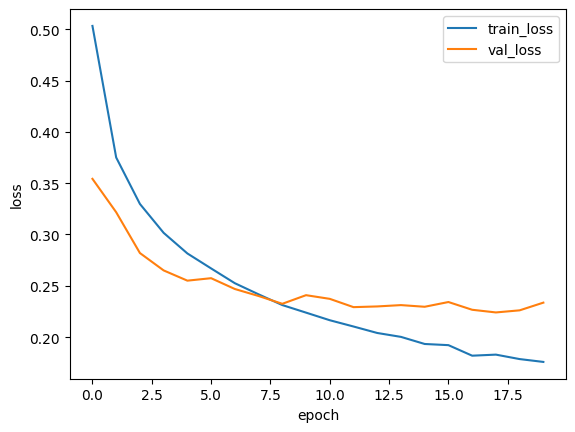

In [33]:
# 정확도 그래프 그리기1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

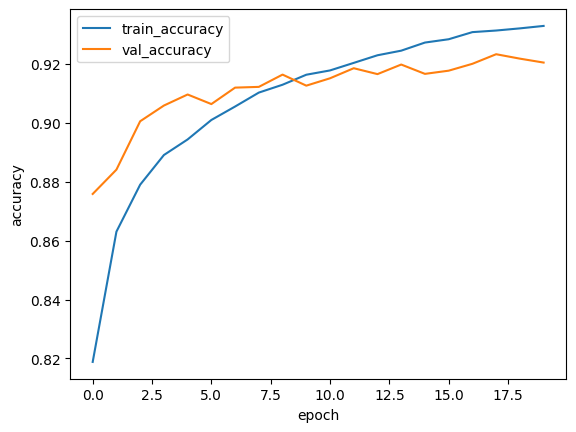

In [34]:
# 정확도 그래프 그리기2
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()